In [285]:
from ipypb import track as tqdm
import torch
import astar
import diffplan
import matplotlib.pyplot as plt
import numpy as np
import itertools
import numba
import random
import search
%load_ext autoreload
%autoreload 2
%matplotlib inline

eps = torch.finfo().eps

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# demo of A* with and without option

In [603]:
env = diffplan.Grid('''
xxxxxxxxxxxxxxx
x      x      x
x      x      x
x      x      x
x   S  x   G  x
x      x      x
x      x      x
x             x
xxxxxxxxxxxxxxx
''')
h = astar.compute_manhattan_heuristic(env)

In [512]:
dist, cost = astar.compute_astar_matrix(env, h, tqdm=tqdm, samples=10)

 [████████████████████████████████████████████████████████████] 85/85 [00:56<00:01, 0.66s/it]

seed 497972924
49 27.634193420410156
99 27.24156379699707
149 26.91598129272461
199 26.86031150817871
249 26.855016708374023


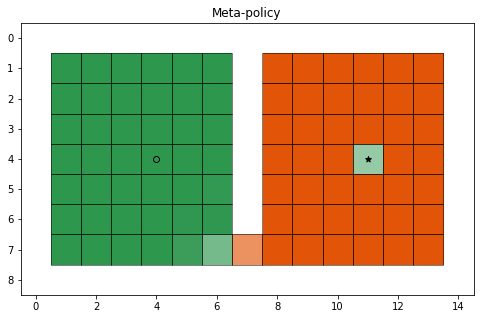

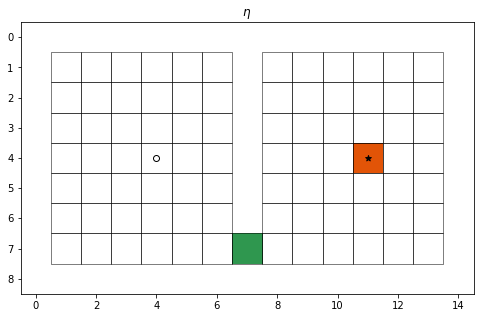

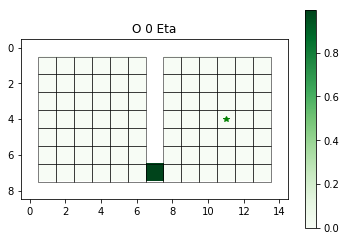

In [513]:
d=diffplan.option_learner_grad(env, search_cost=dist+cost, lr=0.1, grad_steps=250, progress=50, add_goal_options=True, num_options=1, goal_uniform_random=True)

no waypoint nodes visited 28
waypoint nodes visited 13


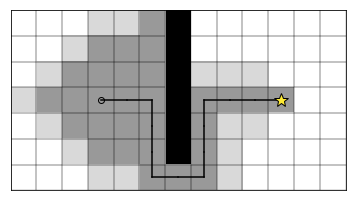

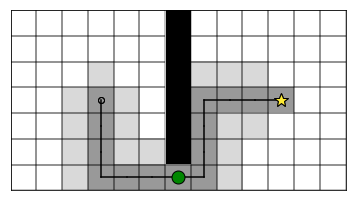

In [604]:
def plot_search(env, visited, frontier, path, ax, notvisited=0, cmap='gray_r'):
#env, state_prop, f=None, ax=None, vmin=None, vmax=None, cmap='Greens', labels=None, vcenter=False, start_states=None, colorbar=True, goal_set=None):
    actions, states = path
    visited = set(visited) | {states[-1]}
    ax.set(
        facecolor='k',
        xticks=[],
        yticks=[],
    )
    for si in env.start_states:
        s = env.states_features[si]
        ax.plot(s[1], s[0], marker='o', c='k', fillstyle='none')

    v = np.full(env.npg.shape, np.nan)
    for si, s in enumerate(env.states_features):
        if si in visited:
            v[s] = .4
        elif si in frontier:
            v[s] = .15
        else:
            v[s] = notvisited
    im = ax.imshow(v, cmap=cmap, vmin=0, vmax=1)

    for patch in diffplan.env_rect(env, linewidth=0.25):
        ax.add_patch(patch)

    for si, nsi in zip(states, states[1:]):
        s = env.states_features[si]
        ns = env.states_features[nsi]
        ax.plot([s[1], ns[1]], [s[0], ns[0]], c='k')

    yellow = (254/255, 234/255, 52/255)
    for g in env.goal_set:
        ax.plot(g[1], g[0], '*', c='k', markeredgecolor='k', markerfacecolor=yellow, markersize=15)

start = env.start_states[0]
goal = env.states_to_idx[list(env.goal_set)[0]]
def astar_search(s, g):
    return astar.a_star_cost(
        env,
        s, g, h,
        shuffle_actions=False,
        return_path=True, return_visited=True,
    )
f, ax = plt.subplots()
r = astar_search(start, goal)
plot_search(env, r['visited'], r['frontier'], r['path'], ax)
print('no waypoint nodes visited', len(r['visited']))
plt.xlim(0.5, 13.5)
plt.ylim(7.5, 0.5)
plt.savefig('figures/astar-no-option.pdf', bbox_inches='tight')

marker_kw = dict(marker='^', markersize=13, markerfacecolor=(0, 0, 0, 0), markeredgecolor=(0, 0, 0, 1))
marker_kw = dict(marker='o', markersize=13, markerfacecolor=(0, 0.53, 0, 1), markeredgecolor=(0, 0, 0, 1))

waypoint = env.states_to_idx[7,7]
f, ax = plt.subplots()
r = astar_search(start, waypoint)
plot_search(env, r['visited'], r['frontier'], r['path'], ax)
r2 = astar_search(waypoint, goal)
plot_search(env, r2['visited'], r2['frontier'] - r['visited'], r2['path'], ax, notvisited=np.nan)
print('waypoint nodes visited', len(r['visited']) + len(r2['visited']))

ax.plot(*env.states_features[waypoint][::-1], c='k', **marker_kw)
plt.xlim(0.5, 13.5)
plt.ylim(7.5, 0.5)
plt.savefig('figures/astar-option.pdf', bbox_inches='tight')

# Open Field

no waypoint nodes visited 49
waypoint nodes visited 26


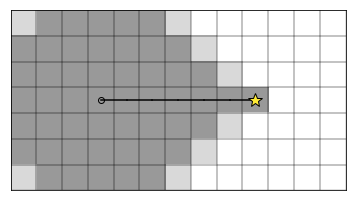

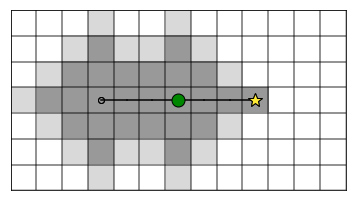

In [605]:
env = diffplan.Grid('''
xxxxxxxxxxxxxxx
x             x
x             x
x             x
x   S     G   x
x             x
x             x
x             x
xxxxxxxxxxxxxxx
''')

start = env.start_states[0]
goal = env.states_to_idx[list(env.goal_set)[0]]
waypoint = 45

f, ax = plt.subplots()
r = search.bfs(env, start, goal)
plot_search(env, r['visited'], r['frontier'], r['path'], ax)
print('no waypoint nodes visited', len(r['visited']))
plt.xlim(0.5, 13.5)
plt.ylim(0.5, 7.5)
plt.savefig('figures/bfs-no-option.pdf', bbox_inches='tight')


f, ax = plt.subplots()
r = search.bfs(env, start, waypoint)
plot_search(env, r['visited'], r['frontier'], r['path'], ax)
r2 = search.bfs(env, waypoint, goal)
plot_search(env, r2['visited'], r2['frontier'] - r['visited'], r2['path'], ax, notvisited=np.nan)
print('waypoint nodes visited', len(r['visited']) + len(r2['visited']))
ax.plot(*env.states_features[waypoint][::-1], c='k', **marker_kw)
plt.xlim(0.5, 13.5)
plt.ylim(0.5, 7.5)
plt.savefig('figures/bfs-option.pdf', bbox_inches='tight')

seed 273615965
49 12.217706680297852
99 11.95942211151123
149 11.944838523864746
199 11.940266609191895
249 11.938200950622559


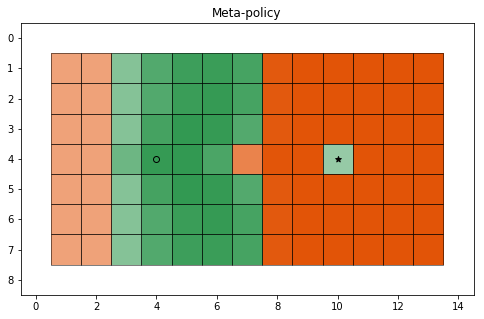

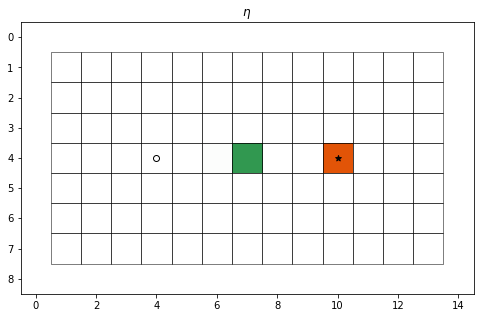

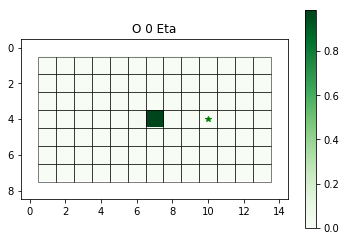

In [299]:
# Making sure it's the waypoint...
d=diffplan.option_learner_grad(env, search_cost=(D+BFS)/4 + 1, lr=0.1, grad_steps=250, progress=50, add_goal_options=True, num_options=1, goal_uniform_random=True)

In [290]:
# in/out

In [535]:
env = diffplan.Grid('''
xxxxxxxxxxxxx
xD      x  Dx
x    x      x
x  xxxxxxxxxx
x       x   x
xxx  x  x   x
xD   x     Dx
xxxxxxxxxxxxx
''')
_env = diffplan.Grid('''
xxxxxxxxxxx
x        Dx
x xxxxxxx x
x      x  x
x  x   x  x
x  x D x  x
x  x   x  x
x  x      x
x xxxxxxx x
xD        x
xxxxxxxxxxx
''')

_env = diffplan.Grid('''
xxxxxxxxxxxxx
x          Dx
x           x
x  xxxxxxx  x
x        x  x
x  x     x  x
x  x  D  x  x
x  x     x  x
x  x        x
x  xxxxxxx  x
x           x
xD          x
xxxxxxxxxxxxx
''')
env = diffplan.Grid('''
xxxxxxxxxxx
x        Dx
x xxxxxxx x
x       x x
x x     x x
x x  D  x x
x x     x x
x x       x
x xxxxxxx x
xD        x
xxxxxxxxxxx
''')
_env = diffplan.Grid('''
xxxxxxxxxxxxx
x   x   x   x
x   x  Dx   x
x   xx x    x
x        xxxx
xxxx     x  x
x           x
xD x     x Dx
xxxx     xxxx
x         D x
x   xx xx   x
x   xD  x   x
xxxxxxxxxxxxx
''')

_env = diffplan.Grid('''
xxxxxxxxxxxxx
x   x Dx    x
x      x   Dx
x   xxxx    x
x           x
x        xxxx
xxxx     x  x
x        x  x
xD x       Dx
xxxxxxxxxxxxx
''')

demo = env

h = astar.compute_manhattan_heuristic(demo)
astar_dist, astar_cost = astar.compute_astar_matrix(demo, h, tqdm=tqdm, samples=50)
demo.astar = astar_dist + astar_cost

 [████████████████████████████████████████████████████████████] 59/59 [01:47<00:02, 1.81s/it]

seed 215022125
24 20.640287399291992
49 18.656923294067383
74 18.209386825561523
99 18.131275177001953
124 18.080440521240234
149 18.065488815307617
174 18.06197166442871
199 18.060422897338867
224 18.05950164794922
249 18.058874130249023
274 18.05841827392578
299 18.058074951171875
324 18.057802200317383
349 18.057584762573242
374 18.057411193847656
399 18.057260513305664


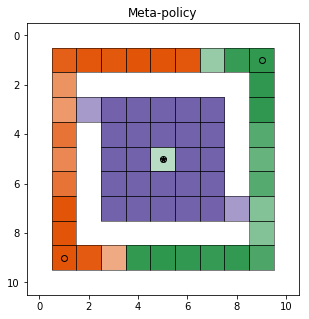

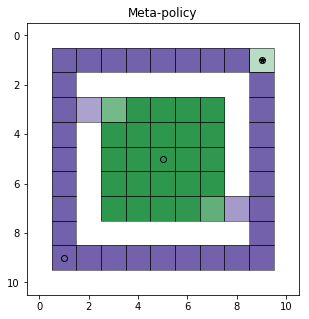

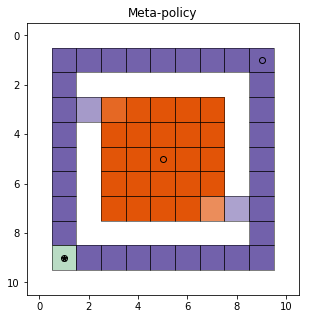

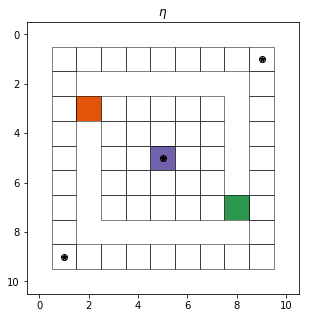

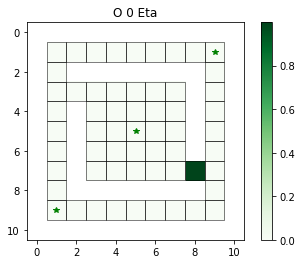

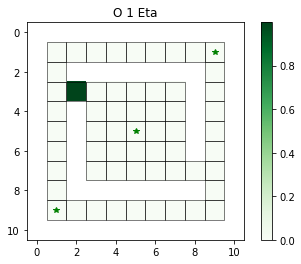

In [536]:
d=diffplan.option_learner_grad(
    demo,
    seed=215022125,
    search_cost=demo.astar, lr=0.1, reset=1000, grad_steps=400, progress=25, goal_uniform_random=True, add_goal_options=True, num_options=2, show_all_metapolicies=True,
)


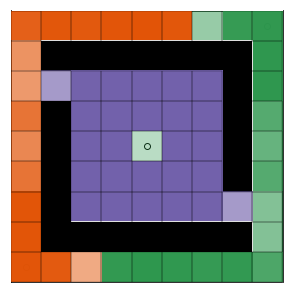

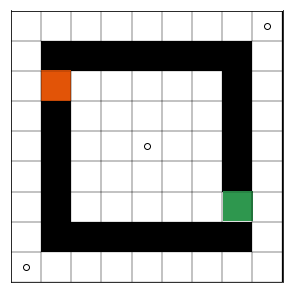

In [606]:
goal_env = d['goal_envs'][0]
assert goal_env.goal_set == {(5,5)}
eta = d['terminations'].softmax(1)
policy = d['res'][3]

lim = (0.5, 9.5)

fmeta, axmeta = plt.subplots(figsize=(10, 5))
diffplan.show_policy_or_eta(goal_env, policy, colorbar=False, env_rect_kw=dict(linewidth=0.25))
axmeta.set(
    fc='k',
    xticks=[],
    yticks=[],
    xlim=lim,
    ylim=lim[::-1],
)
plt.savefig('figures/td-demo-policy.pdf', bbox_inches='tight')

f, ax = plt.subplots(figsize=(10, 5))
diffplan.show_policy_or_eta(goal_env, eta.T, colorbar=False, env_rect_kw=dict(linewidth=0.25))
ax.set(
    fc='k',
    xticks=[],
    yticks=[],
    xlim=lim,
    ylim=lim[::-1],
)
plt.savefig('figures/td-demo-terminations.pdf', bbox_inches='tight')

# 4 rooms - BFS

CPU times: user 9.08 s, sys: 73.4 ms, total: 9.16 s
Wall time: 9.34 s
seed 808431572
19 58.978355407714844
39 57.7877197265625
59 54.794395446777344
79 52.72170639038086
99 52.46784973144531
99 Reset optimizer state
119 52.421817779541016
139 52.41806411743164
159 52.417320251464844
179 52.41700744628906
199 52.41683578491211
199 Reset optimizer state
219 52.41637420654297
239 52.416481018066406
CPU times: user 12min 51s, sys: 15.9 s, total: 13min 7s
Wall time: 13min 34s


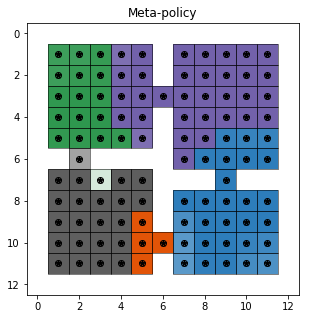

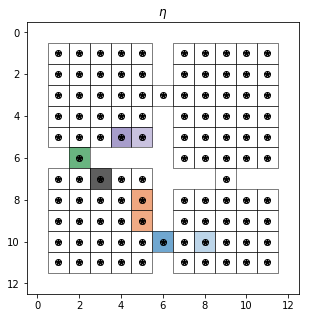

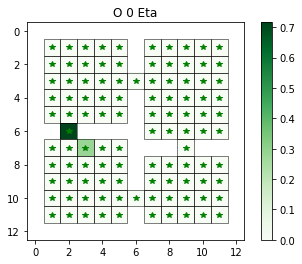

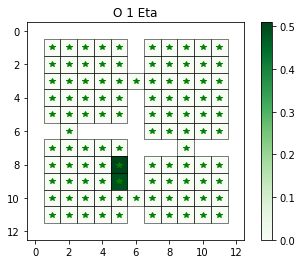

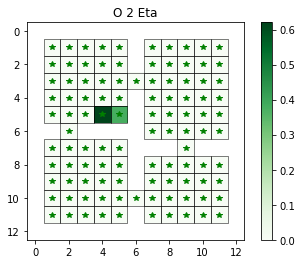

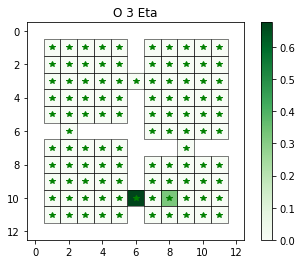

In [39]:

env = diffplan.Grid('''
xxxxxxxxxxxxx
x     x     x
x     x     x
x           x
x     x     x
x     x     x
xx xxxx     x
x     xxx xxx
x     x     x
x     x     x
x           x
x     x     x
xxxxxxxxxxxxx
''')
env.start_states = env.states
env.goal_set = set(env.states_features)
%time D = diffplan.compute_distance_matrix(env)
BFS = diffplan.compute_bfs_matrix(env, D)
%time d=diffplan.option_learner_grad(env, search_cost=D+BFS, lr=0.1, reset=100, grad_steps=250, progress=20, goal_uniform_random=True, add_goal_options=True, num_options=4)

# 4 rooms - A*

In [502]:
env = diffplan.Grid('''
xxxxxxxxxxxxx
x     x     x
x     x     x
x        S  x
x     x     x
x     x     x
xx xxxx     x
x     xxx xxx
x     x     x
x     x     x
x  G        x
x     x     x
xxxxxxxxxxxxx
''')

h = astar.compute_manhattan_heuristic(env)
%time astar_dist, astar_cost = astar.compute_astar_matrix(env, h, tqdm=tqdm, samples=10)

 [████████████████████████████████████████████████████████████] 104/104 [01:24<00:01, 0.80s/it]

CPU times: user 44.4 s, sys: 37 s, total: 1min 21s
Wall time: 1min 23s


seed 943691737
19 19.375518798828125
39 17.98621940612793
59 17.001066207885742
79 16.672367095947266
99 16.514297485351562
99 Reset optimizer state
119 16.499528884887695
139 16.49896240234375
159 16.498863220214844
179 16.498825073242188
199 16.498798370361328
199 Reset optimizer state
CPU times: user 6min 11s, sys: 6.65 s, total: 6min 17s
Wall time: 6min 20s


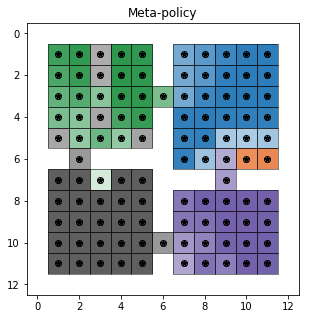

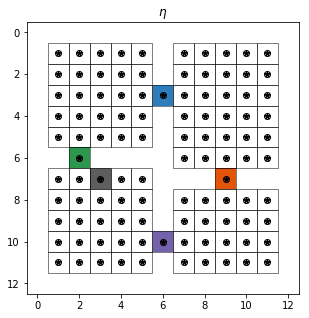

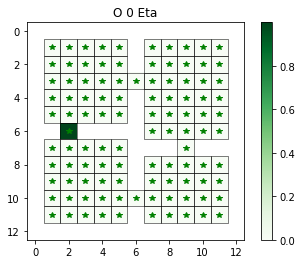

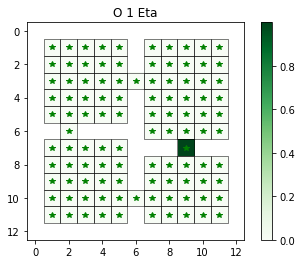

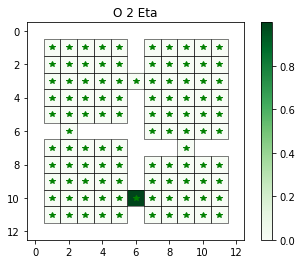

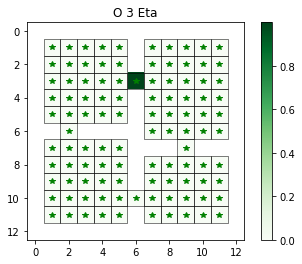

In [510]:
env.start_states = env.states
env.goal_set = set(env.states_features)
%time d=diffplan.option_learner_grad(env, search_cost=astar_dist+astar_cost, lr=0.1, reset=100, grad_steps=200, progress=20, goal_uniform_random=True, add_goal_options=True, num_options=4)

# 3-room - A*

In [40]:
env = diffplan.Grid('''
xxxxxxxxx
x       x
x   xxx x
xG  x   x
xxxxx   x
x   x xxx
x   x   x
xS      x
xxxxxxxxx
''')
h = astar.compute_manhattan_heuristic(env)
astar_dist, astar_cost = astar.compute_astar_matrix(env, h, tqdm=tqdm, samples=20)

 [████████████████████████████████████████████████████████████] 37/37 [00:17<00:00, 0.47s/it]

seed 1038289416
19 50.60833740234375
39 48.38460159301758
59 46.45713424682617
79 45.296722412109375
99 44.423866271972656
99 Reset optimizer state
119 43.414119720458984
139 43.24078369140625
159 43.23030090332031
179 43.227806091308594
199 43.226497650146484
199 Reset optimizer state
219 43.221553802490234
239 43.221351623535156
259 43.221309661865234
279 43.22129440307617
299 43.2213020324707
299 Reset optimizer state
319 43.22125244140625
339 43.22124481201172
CPU times: user 5.53 s, sys: 85.8 ms, total: 5.62 s
Wall time: 5.64 s


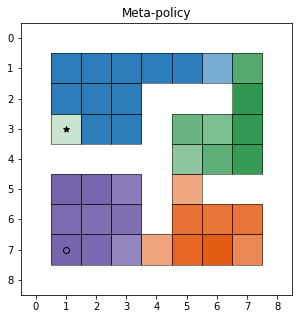

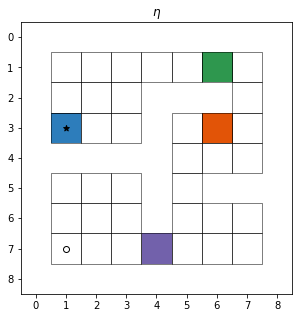

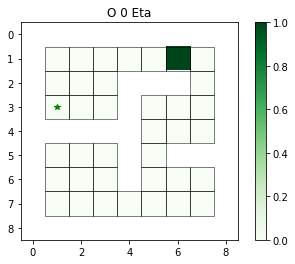

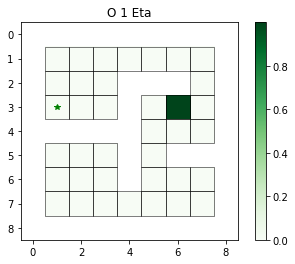

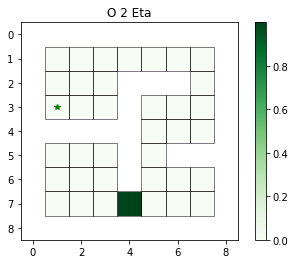

In [38]:
%time d=diffplan.option_learner_grad(env, search_cost=astar_dist+astar_cost, lr=0.1, reset=100, grad_steps=350, progress=20, goal_uniform_random=True, num_options=3, add_goal_options=True)
